# Imports

In [135]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder, StandardScaler
    
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Understanding Data

In [136]:
# Importing the dataset
df = pd.read_csv('telco_churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [137]:
churn_percentage = df['Churn'].value_counts()[1]/df['Churn'].value_counts().sum()*100
print(f'The percentage of customers who have churned in the last month is {round(churn_percentage,2)}%')

The percentage of customers who have churned in the last month is 26.54%


It's important to keep this in mind for later when we will be assessing categorical variables.

In [138]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

**Variable Segmentation**
- Customer --> ['customer_id', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'] 
- Services --> ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity, 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
- Account --> ['Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

**Target Variable**
- Churn --> categorical variable, can have as values 'Yes' or 'No'

In [139]:
#gives us us shape, dtypes, and also null values of our data 
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


We can see that we have no null values in our data, but upon closer inspection, we find that the TotalCharges column has null values represented as a blank space

In [140]:
#find null values
df[df['TotalCharges'] == " "]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


There are only 11 null values, so dropping the rows won't significantly affect the performance

In [141]:
df.drop(df[df['TotalCharges'] == " "].index, inplace=True)
#since it's a numerical feature, we need to convert it to a float dtype
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [142]:
#we also want to drop the customerID column, which we won't need for our analysis
df.drop(['customerID'], axis=1, inplace=True)

# EDA
Let's start with numerical features.

In [143]:
num_feat = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[num_feat].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


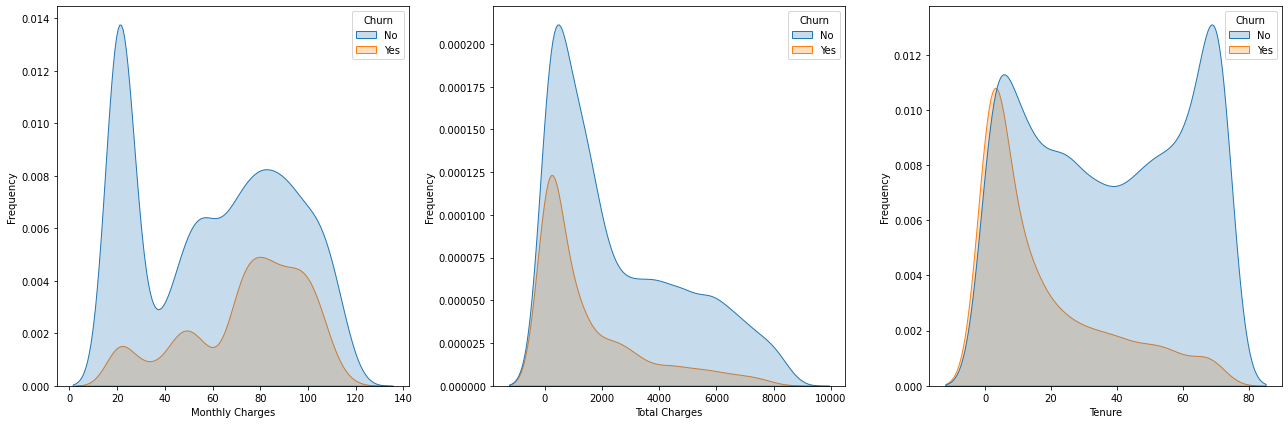

In [144]:
#plotting distributions of numerical variables divided by churn 
fig, ax  = plt.subplots(1, 3, figsize=(18, 6))

ax0 = sns.kdeplot(x = df['MonthlyCharges'],  hue= df['Churn'], ax= ax[0],  fill=True)
ax0.set(xlabel= 'Monthly Charges', ylabel= 'Frequency')

ax1 = sns.kdeplot(x = df['TotalCharges'], hue= df['Churn'], ax= ax[1],   fill=True)
ax1.set(xlabel= 'Total Charges', ylabel= 'Frequency')

ax2 = sns.kdeplot(x = df['tenure'], hue= df['Churn'], ax= ax[2],  fill=True)
ax2.set(xlabel= 'Tenure', ylabel= 'Frequency')

plt.tight_layout()
plt.show()

- customers with higher monthly charges are more likely to churn
- customers with lower total charges are more likely to churn
- customers with lower tenure are more likely to churn

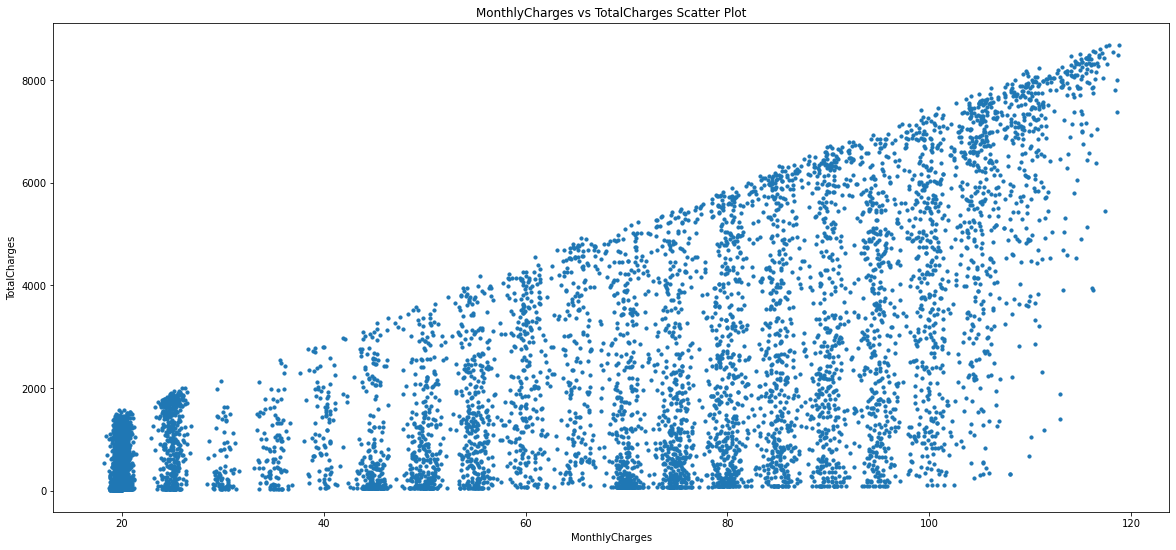

In [145]:
#it'd be interesting to see how monthly charges compare to total charges
plt.figure(figsize=(20,9))
plt.scatter(x = df['MonthlyCharges'],y=df['TotalCharges'],s=10)
plt.xlabel('MonthlyCharges')
plt.ylabel('TotalCharges')
plt.title('MonthlyCharges vs TotalCharges Scatter Plot')
plt.show()

From the graph we can see that the features are correlated, following approximately a linear relationship.
Probably the points lower in the graph are the customers with lower tenure, and as the time they spend with the company increases, the more the Total Charges variable is high.
Let's now quantitatively assess the correlation.

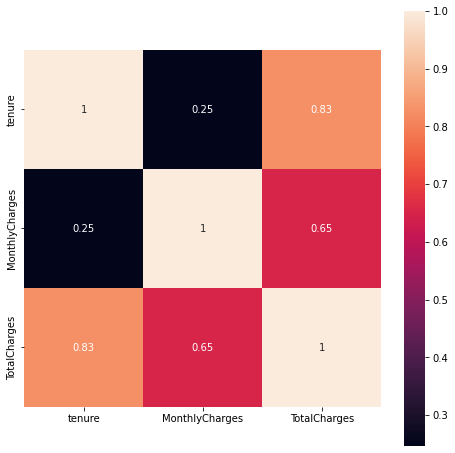

In [146]:
plt.figure(figsize=(8, 8))
sns.heatmap(df[num_feat].corr(), annot = True, square=True)
plt.show()

Now onto categorical variables that represent services the costumer has signed up for

In [147]:
services = ['PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

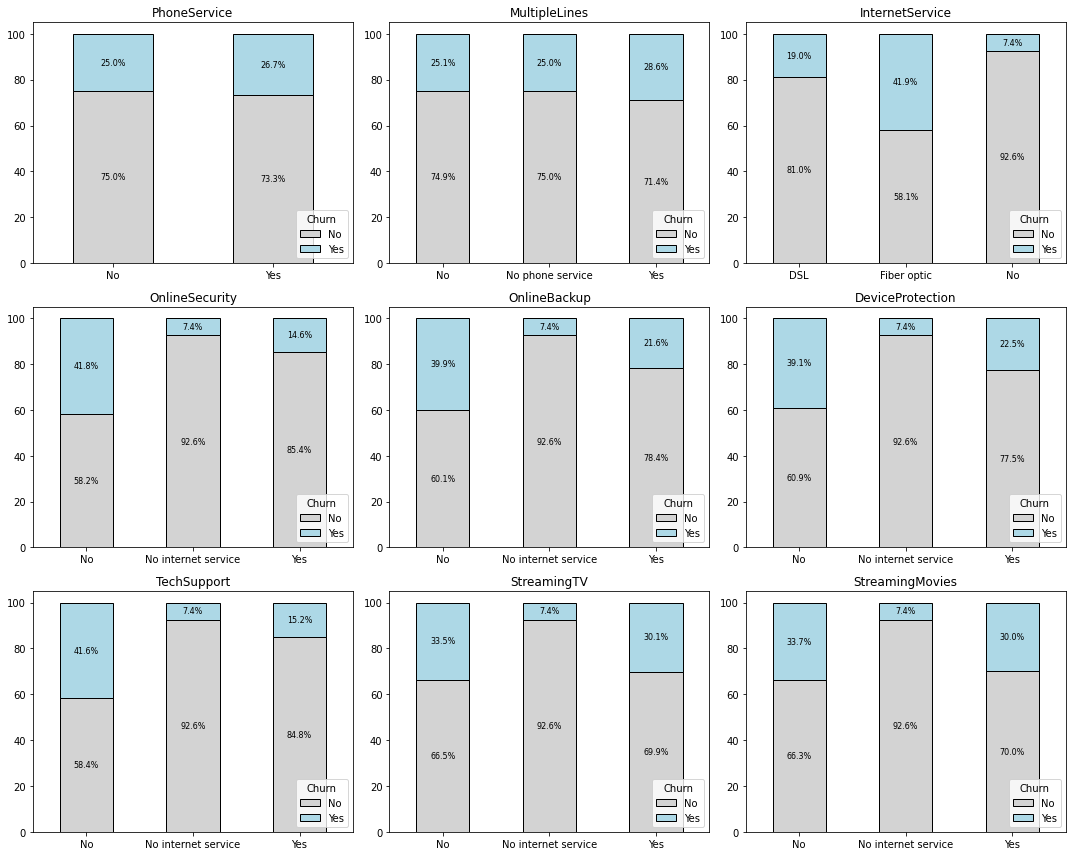

In [148]:
fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (15,12))
for i, item in enumerate(services[:3]):
    contract_churn_percent = df.groupby([item, 'Churn']).size() / df.groupby(item).size() * 100
    pivot_df = contract_churn_percent.unstack()
    ax = pivot_df.plot(kind='bar', stacked=True, color=['lightgrey', 'lightblue'], edgecolor='black', ax=axes[0,i], rot=0)
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=8)
        ax.set_title(item)
        ax.set_xlabel('')
        ax.legend(title='Churn',loc='lower right')
for i, item in enumerate(services[3:6]):
    contract_churn_percent = df.groupby([item, 'Churn']).size() / df.groupby(item).size() * 100
    pivot_df = contract_churn_percent.unstack()
    ax = pivot_df.plot(kind='bar', stacked=True, color=['lightgrey', 'lightblue'], edgecolor='black', ax=axes[1,i], rot=0)
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=8)
        ax.set_title(item)
        ax.set_xlabel('')
        ax.legend(title='Churn',loc='lower right')
for i, item in enumerate(services[6:9]):
    contract_churn_percent = df.groupby([item, 'Churn']).size() / df.groupby(item).size() * 100
    pivot_df = contract_churn_percent.unstack()
    ax = pivot_df.plot(kind='bar', stacked=True, color=['lightgrey', 'lightblue'], edgecolor='black', ax=axes[2,i], rot=0)
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=8)
        ax.set_title(item)
        ax.set_xlabel('')
        ax.legend(title='Churn',loc='lower right')

plt.tight_layout()
plt.show()

All the churn percentages that are considerably higher or lower than 26.58% indicate that the feature can be used for churn prediction.

From the barplots we can see that online sec and online back have very similar percentages,
and since they relate to services that would usually be bought together it makes sense to 
merge them into one variable.

In [149]:
df['OnlineServices'] = df['OnlineSecurity'] +  df['OnlineBackup']
df['OnlineServices'] = df['OnlineServices'].replace({'NoNo': 'No Online Service',
                                                       'YesNo': 'Only Security',
                                                       'NoYes': 'Only Backup',
                                                       'YesYes': 'Both Services',
                                                       'No internet serviceNo internet service':'No internet service'})
df.drop(['OnlineSecurity', 'OnlineBackup'], axis=1, inplace=True)

Same thing we can do with StreamingTV and StreamingMovies.

In [150]:
df['StreamingServices'] = df['StreamingTV'] +  df['StreamingMovies']
df['StreamingServices'] = df['StreamingServices'].replace({'NoNo': 'No Streaming Service', 
                                                         'YesNo': 'Only TV', 
                                                         'NoYes': 'Only Movies', 
                                                         'YesYes': 'Both Services',
                                                         'No internet serviceNo internet service':'No internet service'})
df.drop(['StreamingTV', 'StreamingMovies'], axis=1, inplace=True)

Now let's investigate features that give general info about the customer

In [151]:
cust_info = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

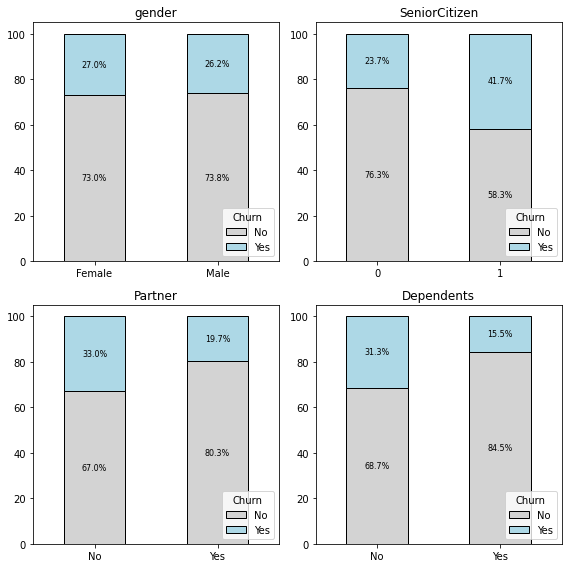

In [152]:
fig, axes = plt.subplots(nrows = 2,ncols = 2,figsize = (8,8))
for i, item in enumerate(cust_info[:2]):
    contract_churn_percent = df.groupby([item, 'Churn']).size() / df.groupby(item).size() * 100
    pivot_df = contract_churn_percent.unstack()
    ax = pivot_df.plot(kind='bar', stacked=True, color=['lightgrey', 'lightblue'], edgecolor='black', ax=axes[0,i], rot=0)
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=8)
        ax.set_title(item)
        ax.set_xlabel('')
        ax.legend(title='Churn',loc='lower right')
for i, item in enumerate(cust_info[2:4]):
    contract_churn_percent = df.groupby([item, 'Churn']).size() / df.groupby(item).size() * 100
    pivot_df = contract_churn_percent.unstack()
    ax = pivot_df.plot(kind='bar', stacked=True, color=['lightgrey', 'lightblue'], edgecolor='black', ax=axes[1,i], rot=0)
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=8)
        ax.set_title(item)
        ax.set_xlabel('')
        ax.legend(title='Churn',loc='lower right')
plt.tight_layout()
plt.show()

- a senior citizen is more likely to churn
- customers without a partner are more likely to churn
- customers that don't have dependents are more likely to churn
- there aren't major differences between sexes

Now let's look at features about customer accounts

In [153]:
payment = ['Contract', 'PaperlessBilling', 'PaymentMethod']

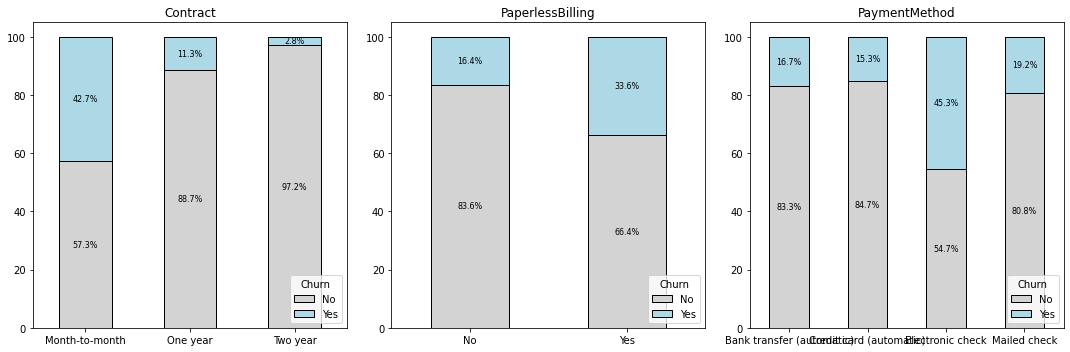

In [154]:
fig, axes = plt.subplots(nrows = 1,ncols = 3,figsize = (15,5))
for i, item in enumerate(payment):
    contract_churn_percent = df.groupby([item, 'Churn']).size() / df.groupby(item).size() * 100
    pivot_df = contract_churn_percent.unstack()
    ax = pivot_df.plot(kind='bar', stacked=True, color=['lightgrey', 'lightblue'], edgecolor='black', ax=axes[i], rot=0)
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=8)
        ax.set_title(item)
        ax.set_xlabel('')
        ax.legend(title='Churn',loc='lower right')

plt.tight_layout()
plt.show()

- As we would expect, contract, being somewhat analogous to tenure, is negatively correlated with churn rate
- Electronic checks seem to have the highest churn rates

# Preprocessing

We use binary encoding where there are 2 categories, otherwise one hot encoding. you can add ordinal encoding if you want to get fancy

In [155]:
le = LabelEncoder()
df_encoded = df.copy()
prefixes = ['MultipleLines ','InternetService ','DeviceProtection ','TechSupport ','Contract ','PaymentMethod ','OnlineServices ','StreamingServices ']
index = 0
for col in df.select_dtypes(object).columns:
    if df[col].nunique() == 2:
        df_encoded[col] = le.fit_transform(df[col])
    else:
        dummies = pd.get_dummies(df[col], drop_first= True, prefix= prefixes[index])
        df_encoded = pd.concat([df_encoded, dummies], axis=1)
        df_encoded.drop(col,axis =1 , inplace= True)
        index += 1 
        
df_encoded

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,PaymentMethod _Electronic check,PaymentMethod _Mailed check,OnlineServices _No Online Service,OnlineServices _No internet service,OnlineServices _Only Backup,OnlineServices _Only Security,StreamingServices _No Streaming Service,StreamingServices _No internet service,StreamingServices _Only Movies,StreamingServices _Only TV
0,0,0,1,0,1,0,1,29.85,29.85,0,...,1,0,0,0,1,0,1,0,0,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,0,1,0,0,0,1,1,0,0,0
2,1,0,0,0,2,1,1,53.85,108.15,1,...,0,1,0,0,0,0,1,0,0,0
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,0,0,0,0,0,1,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,84.80,1990.50,0,...,0,1,0,0,0,1,0,0,0,0
7039,0,0,1,1,72,1,1,103.20,7362.90,0,...,0,0,0,0,1,0,0,0,0,0
7040,0,0,1,1,11,0,1,29.60,346.45,0,...,1,0,0,0,0,1,1,0,0,0
7041,1,1,1,0,4,1,1,74.40,306.60,1,...,0,1,1,0,0,0,1,0,0,0


In [156]:
#normalize features and create test/training sets
X = df_encoded.drop('Churn', axis= 1)
y = df_encoded['Churn']
cols = X.columns.values
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X))
X.columns = cols
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, stratify= y, random_state= 40) 

In [157]:
X

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines _No phone service,...,PaymentMethod _Electronic check,PaymentMethod _Mailed check,OnlineServices _No Online Service,OnlineServices _No internet service,OnlineServices _Only Backup,OnlineServices _Only Security,StreamingServices _No Streaming Service,StreamingServices _No internet service,StreamingServices _Only Movies,StreamingServices _Only TV
0,-1.009430,-0.440327,1.035617,-0.652305,-1.280248,-3.056334,0.828939,-1.161694,-0.994194,3.056334,...,1.404764,-0.543604,-0.673642,-0.52513,2.097837,-0.381152,1.576821,-0.52513,-0.356263,-0.349126
1,0.990658,-0.440327,-0.965608,-0.652305,0.064303,0.327189,-1.206361,-0.260878,-0.173740,-0.327189,...,-0.711863,1.839576,-0.673642,-0.52513,-0.476681,2.623625,1.576821,-0.52513,-0.356263,-0.349126
2,0.990658,-0.440327,-0.965608,-0.652305,-1.239504,0.327189,0.828939,-0.363923,-0.959649,-0.327189,...,-0.711863,1.839576,-0.673642,-0.52513,-0.476681,-0.381152,1.576821,-0.52513,-0.356263,-0.349126
3,0.990658,-0.440327,-0.965608,-0.652305,0.512486,-3.056334,-1.206361,-0.747850,-0.195248,3.056334,...,-0.711863,-0.543604,-0.673642,-0.52513,-0.476681,2.623625,1.576821,-0.52513,-0.356263,-0.349126
4,-1.009430,-0.440327,-0.965608,-0.652305,-1.239504,0.327189,0.828939,0.196178,-0.940457,-0.327189,...,1.404764,-0.543604,1.484468,-0.52513,-0.476681,-0.381152,1.576821,-0.52513,-0.356263,-0.349126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0.990658,-0.440327,1.035617,1.533025,-0.343137,0.327189,0.828939,0.664868,-0.129180,-0.327189,...,-0.711863,1.839576,-0.673642,-0.52513,-0.476681,2.623625,-0.634187,-0.52513,-0.356263,-0.349126
7028,-1.009430,-0.440327,1.035617,1.533025,1.612573,0.327189,0.828939,1.276493,2.241056,-0.327189,...,-0.711863,-0.543604,-0.673642,-0.52513,2.097837,-0.381152,-0.634187,-0.52513,-0.356263,-0.349126
7029,-1.009430,-0.440327,1.035617,1.533025,-0.872808,-3.056334,0.828939,-1.170004,-0.854514,3.056334,...,1.404764,-0.543604,-0.673642,-0.52513,-0.476681,2.623625,1.576821,-0.52513,-0.356263,-0.349126
7030,0.990658,2.271039,1.035617,-0.652305,-1.158016,0.327189,0.828939,0.319168,-0.872095,-0.327189,...,-0.711863,1.839576,1.484468,-0.52513,-0.476681,-0.381152,1.576821,-0.52513,-0.356263,-0.349126


# Modeling

### KNN NEIGHBORS

In [158]:
#tune hyperparameters with gridsearch
k_range = list(range(1, 31))     
param_grid = dict(n_neighbors=k_range)
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
gs = grid.fit(X_train, y_train)
print(f'best parameters: {gs.best_params_} with score: {gs.best_score_}')

best parameters: {'n_neighbors': 28} with score: 0.7873785579287371


In [164]:
#training model with optimal parameters
knn = KNeighborsClassifier(n_neighbors=28)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_pred_proba = knn.predict_proba(X_test)

ROC score: 0.8267842999207955


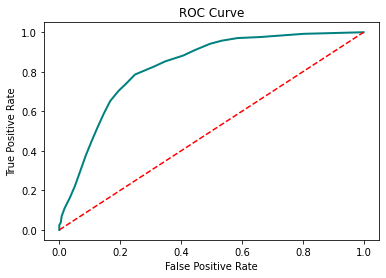

In [165]:
#calculating AUC and plotting curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
print(f'ROC score: {roc_auc_score(y_test,y_pred_proba[:,1])}')
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2, color= 'teal')
plt.plot([0,1], [0,1], 'r--' )
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### LOGISTIC REGRESSION

In [174]:
#tune hyperparameters with gridsearch
param_grid = {'solver': ['lbfgs', 'liblinear'], 'C': [0.001, 0.01, 0.1, 1, 10]}
lr = LogisticRegression(random_state=20)
grid = GridSearchCV(lr, param_grid=param_grid, cv=10, scoring='accuracy')
gs = grid.fit(X_train, y_train)
print(f'best parameters: {gs.best_params_} with score: {gs.best_score_}')

best parameters: {'C': 1, 'solver': 'liblinear'} with score: 0.8010672996087307


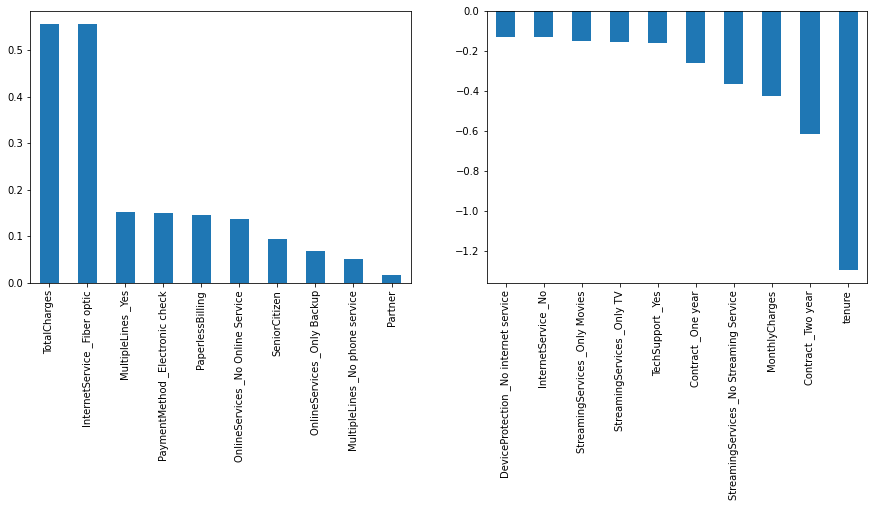

In [175]:
#training model with optimal parameters
lr = LogisticRegression(C=1, solver='liblinear', random_state=20)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)

fig, ax = plt.subplots(1,2,figsize=(15,5))

params = pd.Series(lr.coef_[0],
                 index=X.columns.values)
params.sort_values(ascending=False).iloc[:10].plot(kind='bar', ax=ax[0])
params.sort_values(ascending=False).iloc[-10:].plot(kind='bar', ax=ax[1])
plt.show()

Total Charges and Fiber Optic seem to predict Churn, while tenure and a Two-Year contract (which are related) negatively predict Churn.
From a company standpoint, they might want to evaluate their Fiber Optic service, because it might be overpriced or not satisfying customer expectations.

ROC score: 0.8611981094470702


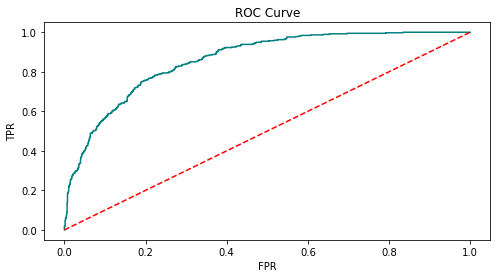

In [128]:
#calculating AUC and plotting curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
print(f'ROC score: {roc_auc_score(y_test,y_pred_proba[:,1])}')
plt.figure(figsize=(8,4))
plt.plot(fpr, tpr, color= 'teal')
plt.plot([0,1], [0,1], 'r--' )
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()

### SUPPORT VECTOR MACHINE

In [178]:
#tune hyperparameters with gridsearch
param_range = [0.001, 0.01, 0.1, 1, 10]
param_grid = [{'C': param_range, 'kernel': ['linear']}, {'C': param_range, 'gamma': param_range,'kernel': ['rbf']}]
svc = SVC(random_state=20)
grid = GridSearchCV(svc, param_grid=param_grid, cv=10, scoring='accuracy')
gs = grid.fit(X_train, y_train)
print(f'best parameters: {gs.best_params_} with score: {gs.best_score_}')

best parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'} with score: 0.8023134833094188


In [179]:
#training model with optimal parameters
svc = SVC(C=10, gamma=0.001, kernel='rbf', probability=True, random_state=20)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
y_pred_proba = svc.predict_proba(X_test)

ROC score: 0.8456005301002738


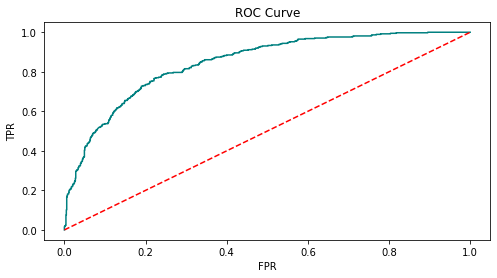

In [180]:
#calculating AUC and plotting curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
print(f'ROC score: {roc_auc_score(y_test,y_pred_proba[:,1])}')
plt.figure(figsize=(8,4))
plt.plot(fpr, tpr, color= 'teal')
plt.plot([0,1], [0,1], 'r--' )
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()

### RANDOM FOREST

In [176]:
#tune hyperparameters with gridsearch
param_grid = {'n_estimators': [100, 200, 300, 400]}
rf = RandomForestClassifier(random_state=20)
grid = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring='accuracy')
gs = grid.fit(X_train, y_train)
print(f'best parameters: {gs.best_params_} with score: {gs.best_score_}')

best parameters: {'n_estimators': 300} with score: 0.7934207948016156


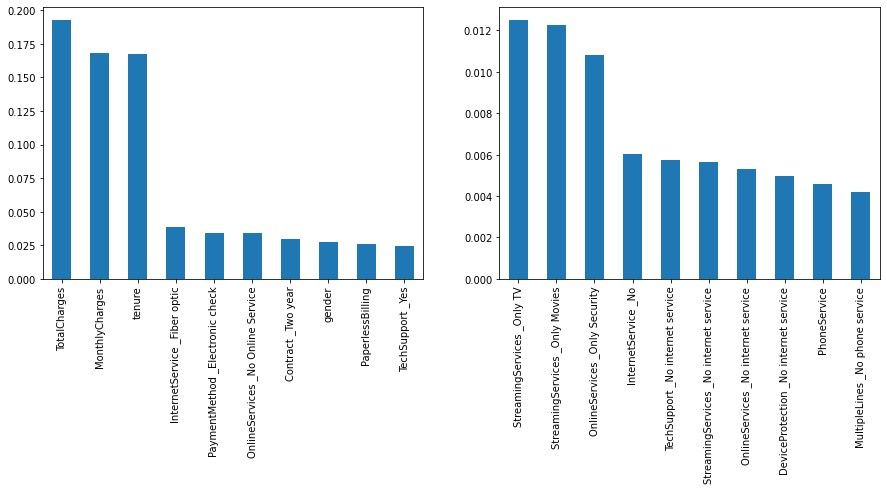

In [177]:
rf = RandomForestClassifier(n_estimators=300, random_state=20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

fig, ax = plt.subplots(1,2,figsize=(15,5))

importances = pd.Series(rf.feature_importances_,
                 index=X.columns.values)
importances.sort_values(ascending=False).iloc[:10].plot(kind='bar', ax=ax[0])
importances.sort_values(ascending=False).iloc[-10:].plot(kind='bar', ax=ax[1])
plt.show()

Here Random Forest tells us that the features that help us the most with predicting customer churn are TotalCharges, MonthlyCharges and tenure.

ROC score: 0.8404069451418692


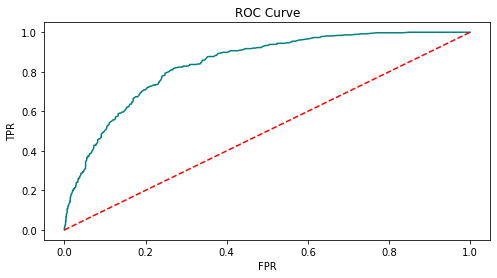

In [134]:
#calculating AUC and plotting curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
print(f'ROC score: {roc_auc_score(y_test,y_pred_proba[:,1])}')
plt.figure(figsize=(8,4))
plt.plot(fpr, tpr, color= 'teal')
plt.plot([0,1], [0,1], 'r--' )
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()

# Conclusion
Logistic Regression seems to be the best model for this problem with a ROC-AUC score of 0.86